<a href="https://colab.research.google.com/github/gstvmt/lia1-2023-1/blob/main/Entregas%20-%20GustavoMotaBarros/Entrega%208%20-%20How_does_a_neural_net_really_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ajustando uma funcao com o gradient descent

In [1]:
from ipywidgets import interact
from fastai.basics import *

plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

Vamos tentar ajustar uma funcao quadratica

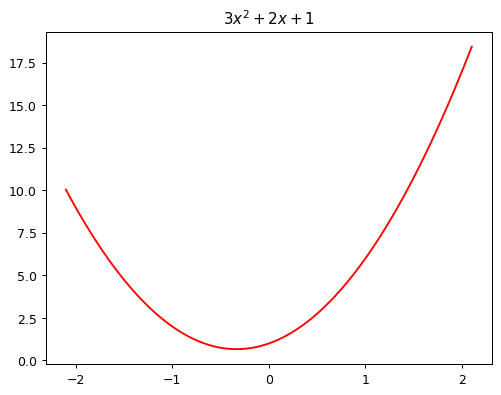

In [2]:
def f(x): return 3*x**2 + 2*x + 1

plot_function(f, "$3x^2 + 2x + 1$")

Criando uma funcao que calcula o valor referente a um ponto em qualquer funcao quadratica

In [3]:
def quad(a, b, c, x): return a*x**2 + b*x + c

In [4]:
# a funcao mkquad cria uma funcao quadratica com os valores de a,b e c fixos usando o metodo partial()
def mk_quad(a,b,c): return partial(quad, a,b,c)

6

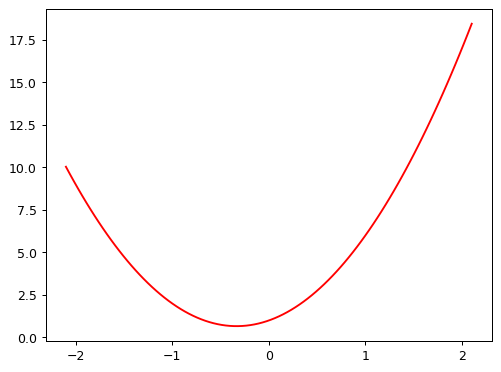

In [5]:
f2 = mk_quad(3,2,1)
plot_function(f2)
f2(1)

Agora iremos tirar algumas amostras, contendo um leve desvio, da quadratica construida e iremos ajustar os parametros de uma quadratica qualquer para aproximar a funcao que criou os dados.

In [6]:
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

In [7]:
np.random.seed(42)

x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(f(x), 0.15, 1.5)

In [8]:
# Amostras criadas
x[:5],y[:5]

(tensor([[-2.0000],
         [-1.7895],
         [-1.5789],
         [-1.3684],
         [-1.1579]]),
 tensor([[11.8690],
         [ 6.5433],
         [ 5.9396],
         [ 2.6304],
         [ 1.7947]], dtype=torch.float64))

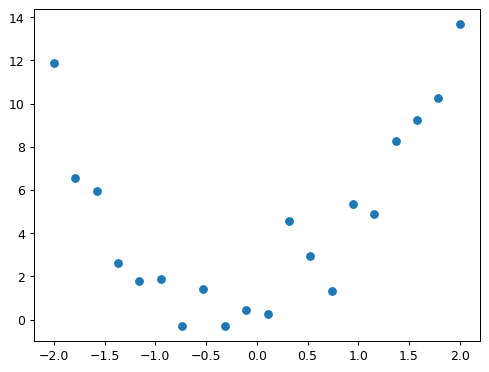

In [9]:
# Grafico das amostras
plt.scatter(x,y);

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

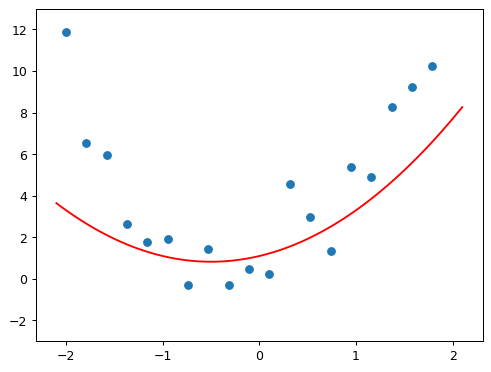

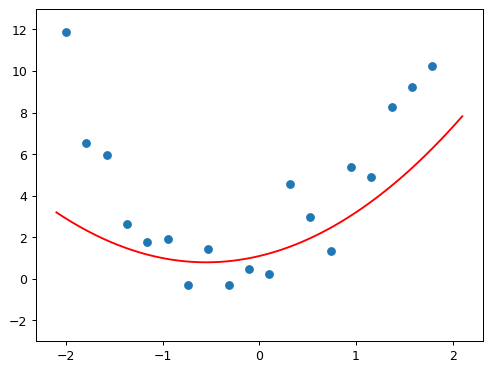

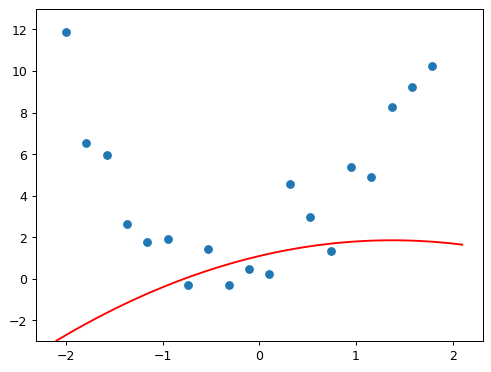

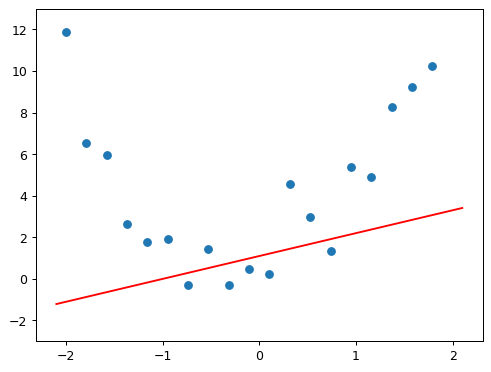

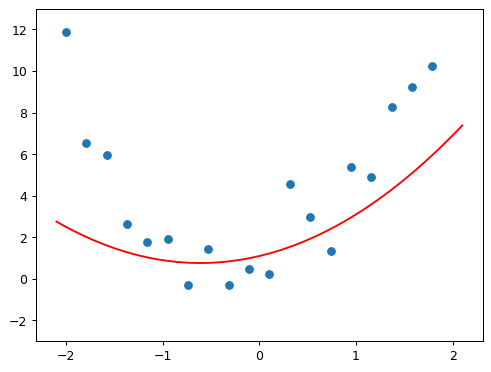

In [10]:
# Um teste para verificar como a curva se adequa aos dados quando se ajusta os parametros
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    plt.scatter(x,y)
    plot_function(mk_quad(a,b,c), ylim=(-3,13))

In [11]:
# mean absolute error --> calcula o erro da funcao em relacao aos dados da amostra
def mae(preds, acts): return (torch.abs(preds-acts)).mean()

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

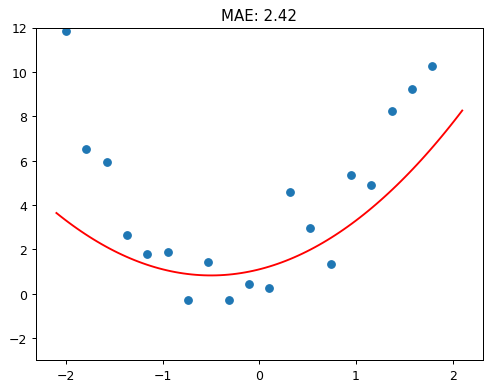

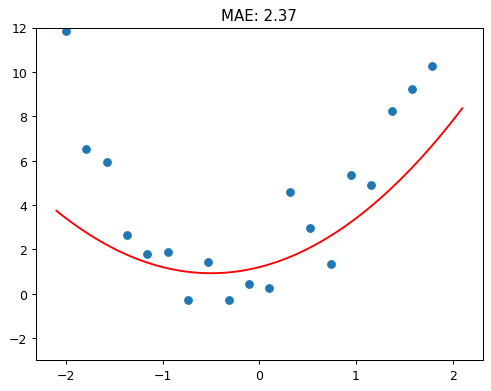

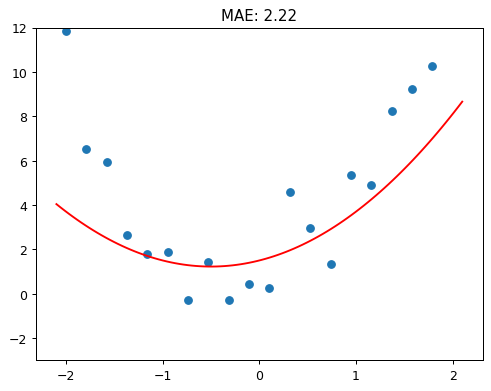

In [12]:
# Um grafico que indica o erro da funcao em relacao a amostra, mas agora com os parametros ajustaveis para se averiguar quais parametros se adequam mais ao conjunto de dados obtidos
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    f = mk_quad(a,b,c)
    plt.scatter(x,y)
    loss = mae(f(x), y)
    plot_function(f, ylim=(-3,12), title=f"MAE: {loss:.2f}")

O proximo passo consiste em encontrar a derivada dos parametros em relacao a funcao mae, pois com estes valores sera possivel ajustar a funcao quadratica aos dados amostrados da melhor forma possivel, ou seja, com o menor erro

In [13]:
def quad_mae(params):
    f = mk_quad(*params)
    return mae(f(x), y)

In [14]:
quad_mae([1.1, 1.1, 1.1])

tensor(2.4219, dtype=torch.float64)

In [15]:
abc = torch.tensor([1.1,1.1,1.1])

In [16]:
# habilita o calculo do gradiente (derivada) para abc
abc.requires_grad_()

tensor([1.1000, 1.1000, 1.1000], requires_grad=True)

In [17]:
# a perda da funcao com os parametros abc
loss = quad_mae(abc)
loss

tensor(2.4219, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [18]:
# obtem o gradiente de abc
loss.backward()

In [19]:
# valor do gradiente de abc
abc.grad

tensor([-1.3529, -0.0316, -0.5000])

In [20]:
# Ajustando os valores dos parametros conforme o gradiente
with torch.no_grad():
    abc -= abc.grad*0.01
    loss = quad_mae(abc)

print(f'loss={loss:.2f}')

loss=2.40


In [21]:
# Apos isso podemos fazer um loop realizando o ajuste dos parametros de forma automatica, o que caracteriza o gradient descent na sua forma automatica
for i in range(10):
    loss = quad_mae(abc)
    loss.backward()
    with torch.no_grad(): abc -= abc.grad*0.01
    print(f'step={i}; loss={loss:.2f}')


step=0; loss=2.40
step=1; loss=2.36
step=2; loss=2.30
step=3; loss=2.21
step=4; loss=2.11
step=5; loss=1.98
step=6; loss=1.85
step=7; loss=1.72
step=8; loss=1.58
step=9; loss=1.46


# Como uma rede neural aproxima qualquer funcao apresentada

Tendo parametros suficientes, uma rede neural consegue aproximar qualquer funcao apresentada realizando o somatorio de n funcoes rectified_linear(), que sao caracterizadas por serem lineares para valores maiores que 0, e 0 para valores menores ou iguais a zero.

In [22]:
# definindo a funcao rectified_linear
def rectified_linear(m,b,x):
    y = m*x+b
    return torch.clip(y, 0.)

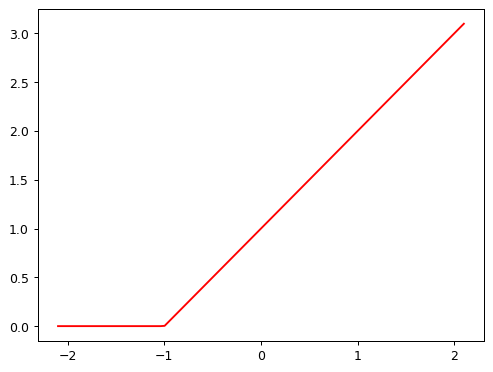

In [23]:
# mostra a funcao
plot_function(partial(rectified_linear, 1,1))

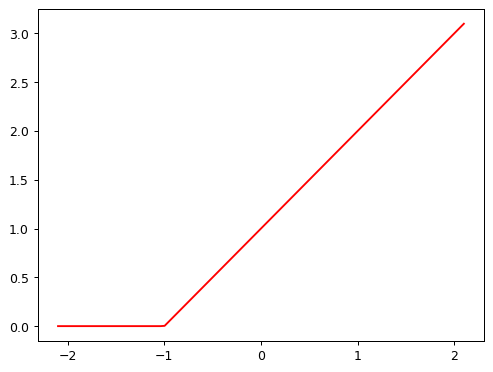

In [24]:
# outra forma de se definir a funcao
import torch.nn.functional as F
def rectified_linear2(m,b,x): return F.relu(m*x+b)
plot_function(partial(rectified_linear2, 1,1))

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

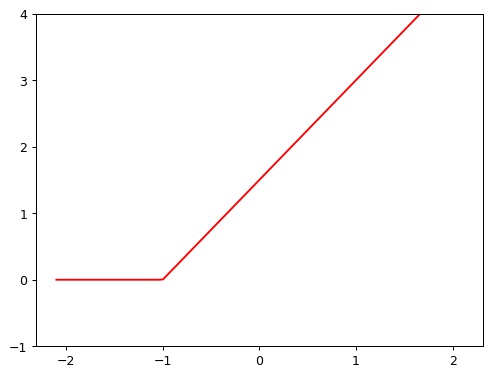

In [25]:
@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plot_function(partial(rectified_linear, m,b), ylim=(-1,4))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

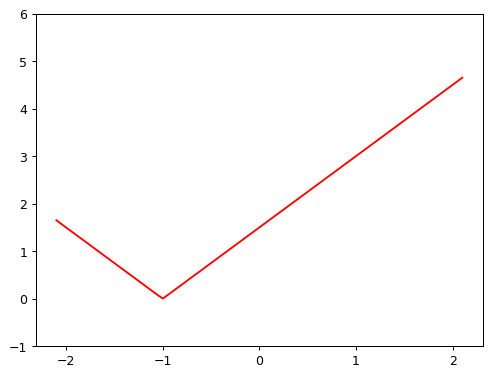

In [26]:
# Com o somatorio de duas funcoes, pode-se analisar o padrao de que qualquer curva, ou seja, funcao, pode ser aproximada pelo ajuste dos parametros de cada funcao a ser somada
def double_relu(m1,b1,m2,b2,x):
    return rectified_linear(m1,b1,x) + rectified_linear(m2,b2,x)

@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_double_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1,b1,m2,b2), ylim=(-1,6))